In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-05 11:14:32.259463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(ii) dataset

In [4]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-30(ii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[0.0234375+0.j        0.015625 +0.0078125j 0.015625 +0.j        ...
 0.03125  -0.0078125j 0.       +0.0078125j 0.0234375+0.j       ]
2048
84921
(2048, 84921)
[0.04259191 0.03362997 0.02526437 ... 0.02303903 0.02592443 0.03146292]
0
(10000, 2048)
(10000,)
[0.0234375+0.0234375j 0.03125  -0.0078125j 0.03125  +0.015625j  ...
 0.0078125+0.j        0.       +0.0078125j 0.015625 -0.015625j ]
2048
90846
(2048, 90846)
[0.02672957 0.01999211 0.01750226 ... 0.01990294 0.01985274 0.01860477]
1
(20000, 2048)
(20000,)
[ 0.015625 +0.j         0.0234375+0.0078125j  0.015625 +0.j        ...
 -0.0078125-0.0078125j  0.03125  -0.0078125j  0.0234375+0.0234375j]
2048
84482
(2048, 84482)
[0.05417342 0.04321303 0.04044964 ... 0.036244   0.04203677 0.04316486]
2
(30000, 2048)
(30000,)
[ 0.0390625-0.0078125j  0.015625 +0.j         0.0078125+0.j        ...
 -0.0078125+0.0078125j  0.0078125+0.j         0.       +0.0234375j]
2048
83385
(2048, 83385)
[0.02831035 0.02287704 0.01580978 ... 0.01231729 0.01352889 0.020

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(ii) dataset 

In [5]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-05 11:46:02.294525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 9s 4ms/step - loss: 17.6553 - accuracy: 6.1250e-04
test loss, test acc: [17.65525245666504, 0.0006125000072643161]


In [8]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[3 4 4 ... 3 3 3]
3
[[   0 7528    5  823 1621    1   13    9]
 [   7    4 4686    0   35 5248    1   19]
 [   0  175    7 9581  186    0   31   20]
 [   2 4695 4813    1   88    8   23  370]
 [  19   39    0    7    0    0 9893   42]
 [   0 1048    3  720 8201    4   16    8]
 [   0  976    1 8319  672    1   23    8]
 [   0   54   10 9752  158    3   13   10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.00      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.00      0.00      0.00     10000
           6       0.00      0.00      0.00     10000
           7       0.02      0.00      0.00     10000

    accuracy                           0.00     80000
   macro avg       0.00      0.00   

Test Accuracy:0.0006125


Text(0.5, 1.0, 'Accuracy:0.001')

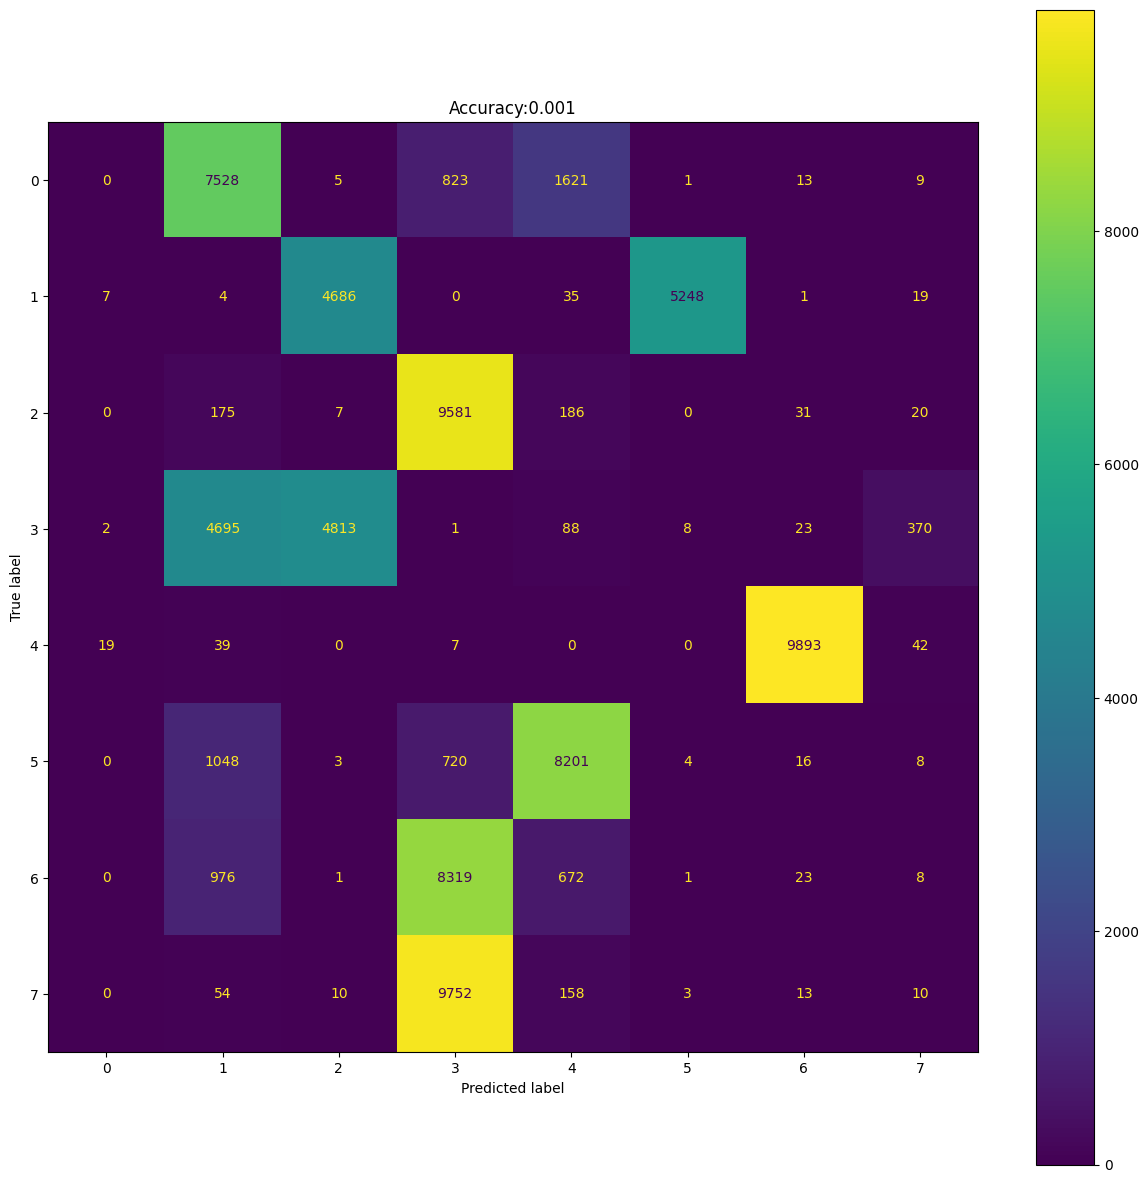

In [9]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(ii) dataset 

In [10]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [11]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [12]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 3.1751 - accuracy: 0.4559
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8822 - accuracy: 0.7659
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7967 - accuracy: 0.8061
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7513 - accuracy: 0.8287
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7215 - accuracy: 0.8410
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6994 - accuracy: 0.8455
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6822 - accuracy: 0.8522
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6682 - accuracy: 0.8550
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6565 - accuracy: 0.8578
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - lo

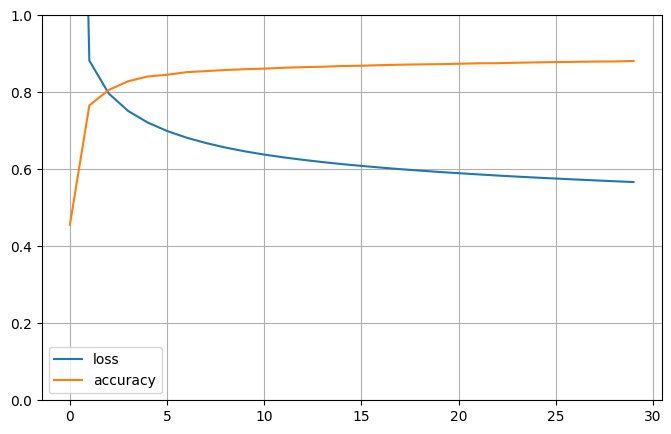

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [14]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5655 - accuracy: 0.8795
test loss, test acc: [0.5654678344726562, 0.8795250058174133]


In [15]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 5 5 ... 7 7 7]
2
[[7817    3   42   25   13 1062 1035    3]
 [   3 9937    0   44    8    8    0    0]
 [ 155   11 8136   27   29  218 1311  113]
 [  31   40    1 9894   24   10    0    0]
 [  18    3    6   31 9935    0    4    3]
 [ 420   15  118   20   16 8871  528   12]
 [ 269    5 2189   16   18 1224 6269   10]
 [  43   17  134    9    8  201   85 9503]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     10000
           1       0.99      0.99      0.99     10000
           2       0.77      0.81      0.79     10000
           3       0.98      0.99      0.99     10000
           4       0.99      0.99      0.99     10000
           5       0.77      0.89      0.82     10000
           6       0.68      0.63      0.65     10000
           7       0.99      0.95      0.97     10000

    accuracy                           0.88     80000
   macro avg       0.88      0.88   

Test Accuracy:0.879525


Text(0.5, 1.0, 'Accuracy:0.880')

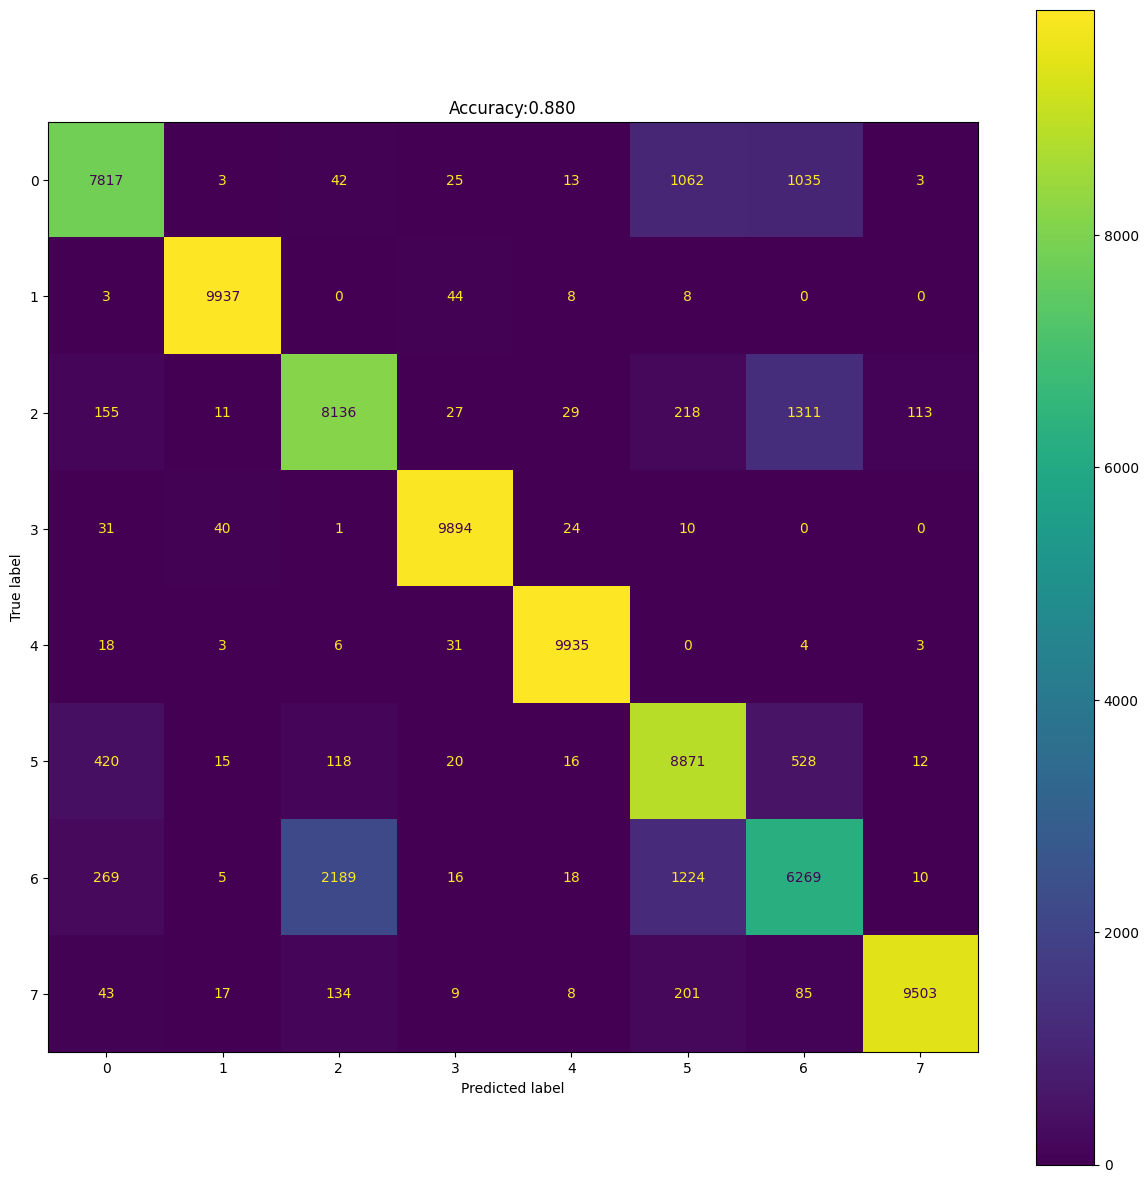

In [16]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(ii) dataset 

In [17]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [18]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 8.8005 - accuracy: 0.1681
test loss, test acc: [8.800477981567383, 0.1681250035762787]


In [19]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[6 6 6 ... 3 3 3]
6
[[   1   14    0 1240    1   15 8728    1]
 [   3 5333  667    5    1 3977   14    0]
 [   1    9    0 5496    0   24 4464    6]
 [   1 8457    2  151    1  754  634    0]
 [ 222   59    0 2842    1    1    0 6875]
 [   2   18    1  529    1   67 9382    0]
 [   1   19    1 2075    0    9 7894    1]
 [   0    6    0 9541    0   14  436    3]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.38      0.53      0.45     10000
           2       0.00      0.00      0.00     10000
           3       0.01      0.02      0.01     10000
           4       0.20      0.00      0.00     10000
           5       0.01      0.01      0.01     10000
           6       0.25      0.79      0.38     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.17     80000
   macro avg       0.11      0.17   

Test Accuracy:0.168125


Text(0.5, 1.0, 'Accuracy:0.168')

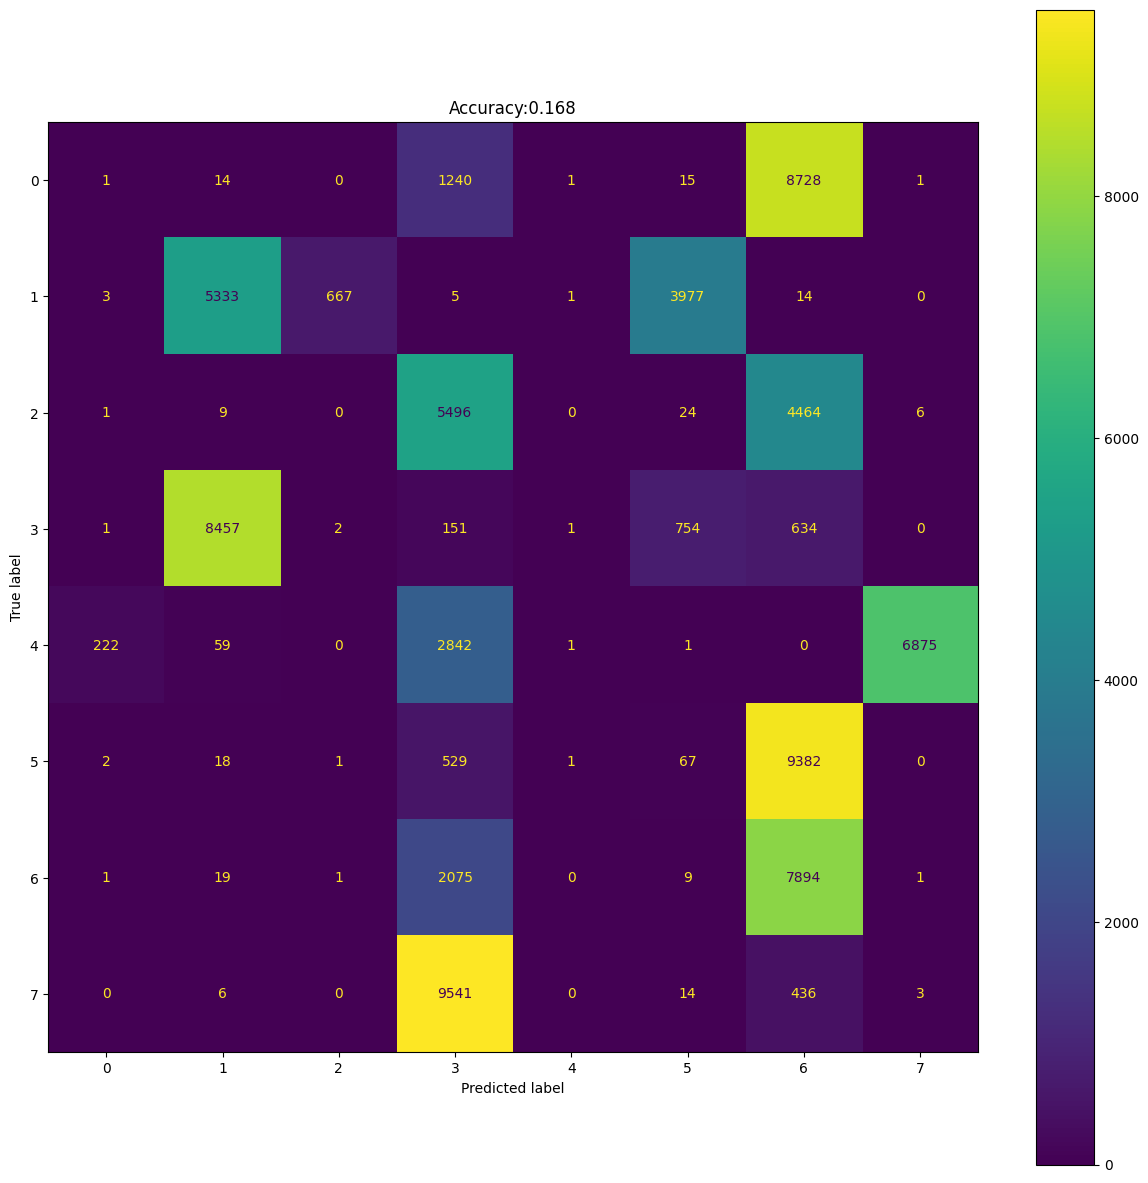

In [20]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [21]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [22]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [23]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8390 - accuracy: 0.5446
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8981 - accuracy: 0.7397
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8380 - accuracy: 0.7678
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8036 - accuracy: 0.7814
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7796 - accuracy: 0.7918
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7610 - accuracy: 0.8017
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7459 - accuracy: 0.8124
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7330 - accuracy: 0.8239
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7218 - accuracy: 0.8330
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - los

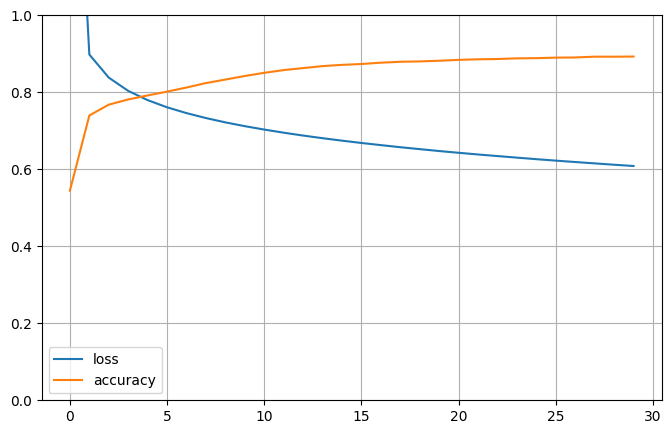

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [25]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 9s 4ms/step - loss: 0.6067 - accuracy: 0.8958
test loss, test acc: [0.6066959500312805, 0.895799994468689]


In [26]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 5 5 ... 7 7 7]
2
[[8494    6   42   47   10  134 1256   11]
 [   5 9601    0  375   11    8    0    0]
 [ 274    9 9079   37   21  169  196  215]
 [  28  409    0 9516   10   37    0    0]
 [   7    6    0   42 9931    0    0   14]
 [ 224   24   46   32    6 9374  244   50]
 [1741    4 1762   31   12  145 6290   15]
 [ 169    8  197   22   15  177   33 9379]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     10000
           1       0.95      0.96      0.96     10000
           2       0.82      0.91      0.86     10000
           3       0.94      0.95      0.95     10000
           4       0.99      0.99      0.99     10000
           5       0.93      0.94      0.94     10000
           6       0.78      0.63      0.70     10000
           7       0.97      0.94      0.95     10000

    accuracy                           0.90     80000
   macro avg       0.90      0.90   

Test Accuracy:0.8958


Text(0.5, 1.0, 'Accuracy:0.896')

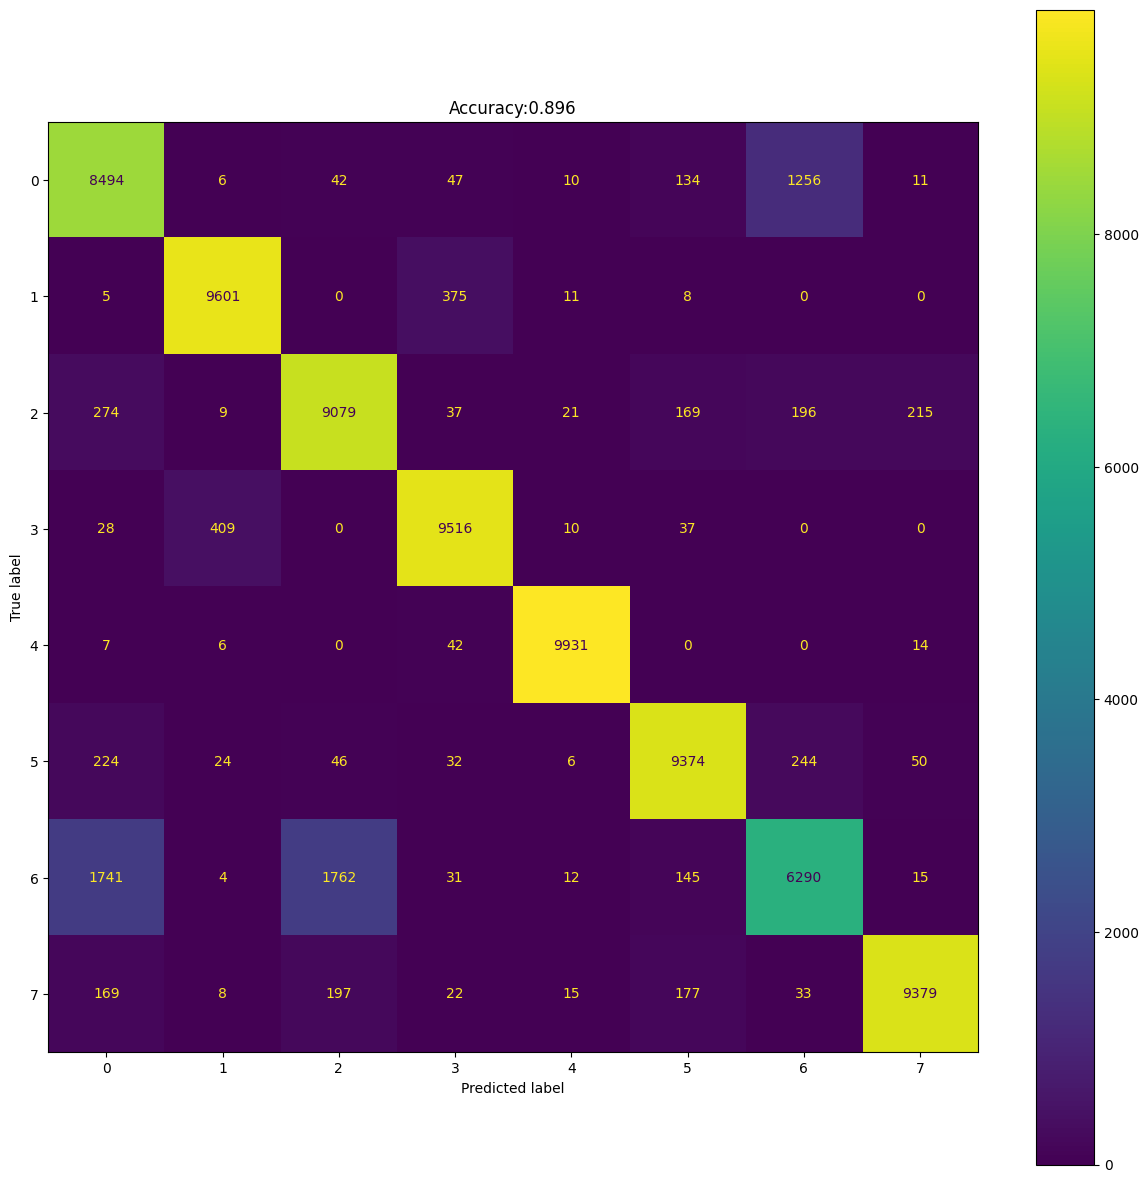

In [27]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(ii) dataset 

In [28]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [29]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 13.4015 - accuracy: 0.1432
test loss, test acc: [13.401528358459473, 0.1431874930858612]


In [30]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 3 3 ... 3 3 3]
3
[[   0  218    3 3674   17    0 6088    0]
 [   5 3247    2    3 1879   79   18 4767]
 [   0   24    3 9755   35    0  183    0]
 [   0 2043    6    0 7639    9   51  252]
 [   5   60  373    0 8083    0 1474    5]
 [   1  128    1 9425    6   16  422    1]
 [   0   31    1 9850   11    1  105    1]
 [   0   25    0 9878    5    2   89    1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.56      0.32      0.41     10000
           2       0.01      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.46      0.81      0.58     10000
           5       0.15      0.00      0.00     10000
           6       0.01      0.01      0.01     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.15      0.14  

Test Accuracy:0.1431875


Text(0.5, 1.0, 'Accuracy:0.143')

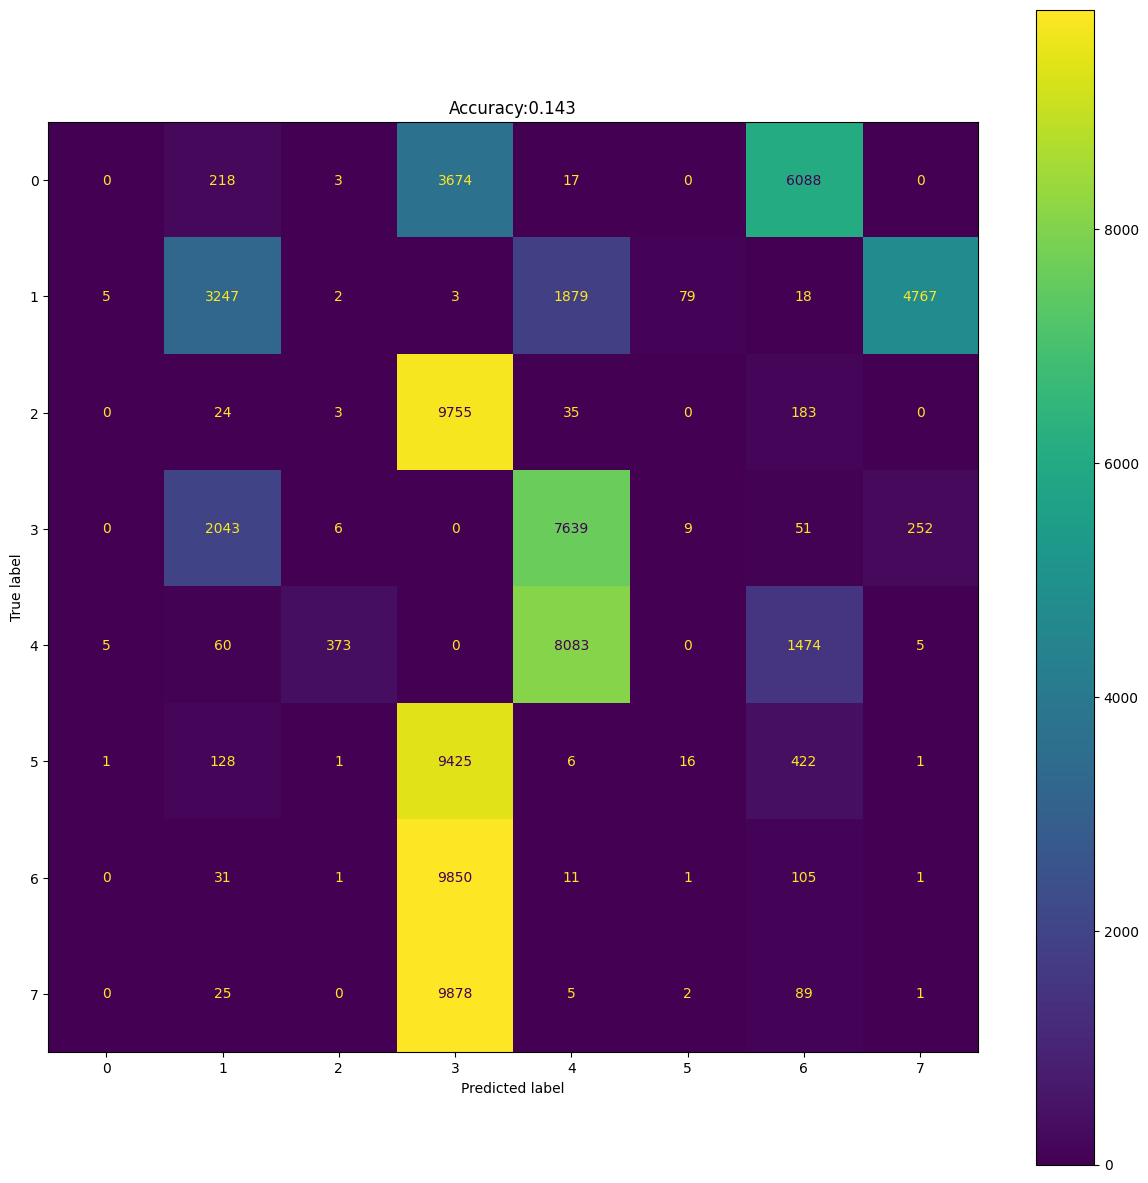

In [31]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(iii) model to Nordic Device-30(ii) dataset 

In [32]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [33]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [34]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.3640 - accuracy: 0.5537
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8985 - accuracy: 0.8355
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7861 - accuracy: 0.8741
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7234 - accuracy: 0.8863
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6825 - accuracy: 0.8933
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6533 - accuracy: 0.8966
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6316 - accuracy: 0.8999
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6145 - accuracy: 0.9011
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6009 - accuracy: 0.9023
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

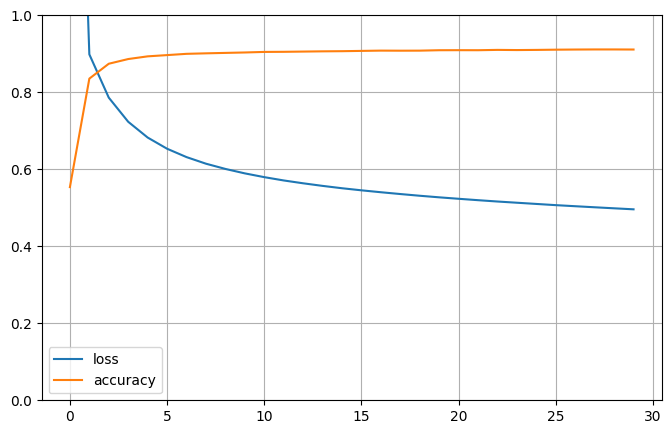

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [36]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.4948 - accuracy: 0.9127
test loss, test acc: [0.49479931592941284, 0.9127374887466431]


In [37]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[7 5 5 ... 7 7 7]
7
[[9698    1   30   12   28  162   66    3]
 [   6 9241    0  706   13   34    0    0]
 [ 160    1 9071   10   37  224  349  148]
 [  20  990    0 8915   56   19    0    0]
 [  30   11    0  121 9831    7    0    0]
 [ 352    2   60   14   16 8655  864   37]
 [ 127    1  963    5   19  753 8116   16]
 [  23    6  219   16    0  188   56 9492]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10000
           1       0.90      0.92      0.91     10000
           2       0.88      0.91      0.89     10000
           3       0.91      0.89      0.90     10000
           4       0.98      0.98      0.98     10000
           5       0.86      0.87      0.86     10000
           6       0.86      0.81      0.83     10000
           7       0.98      0.95      0.96     10000

    accuracy                           0.91     80000
   macro avg       0.91      0.91   

Test Accuracy:0.9127375


Text(0.5, 1.0, 'Accuracy:0.913')

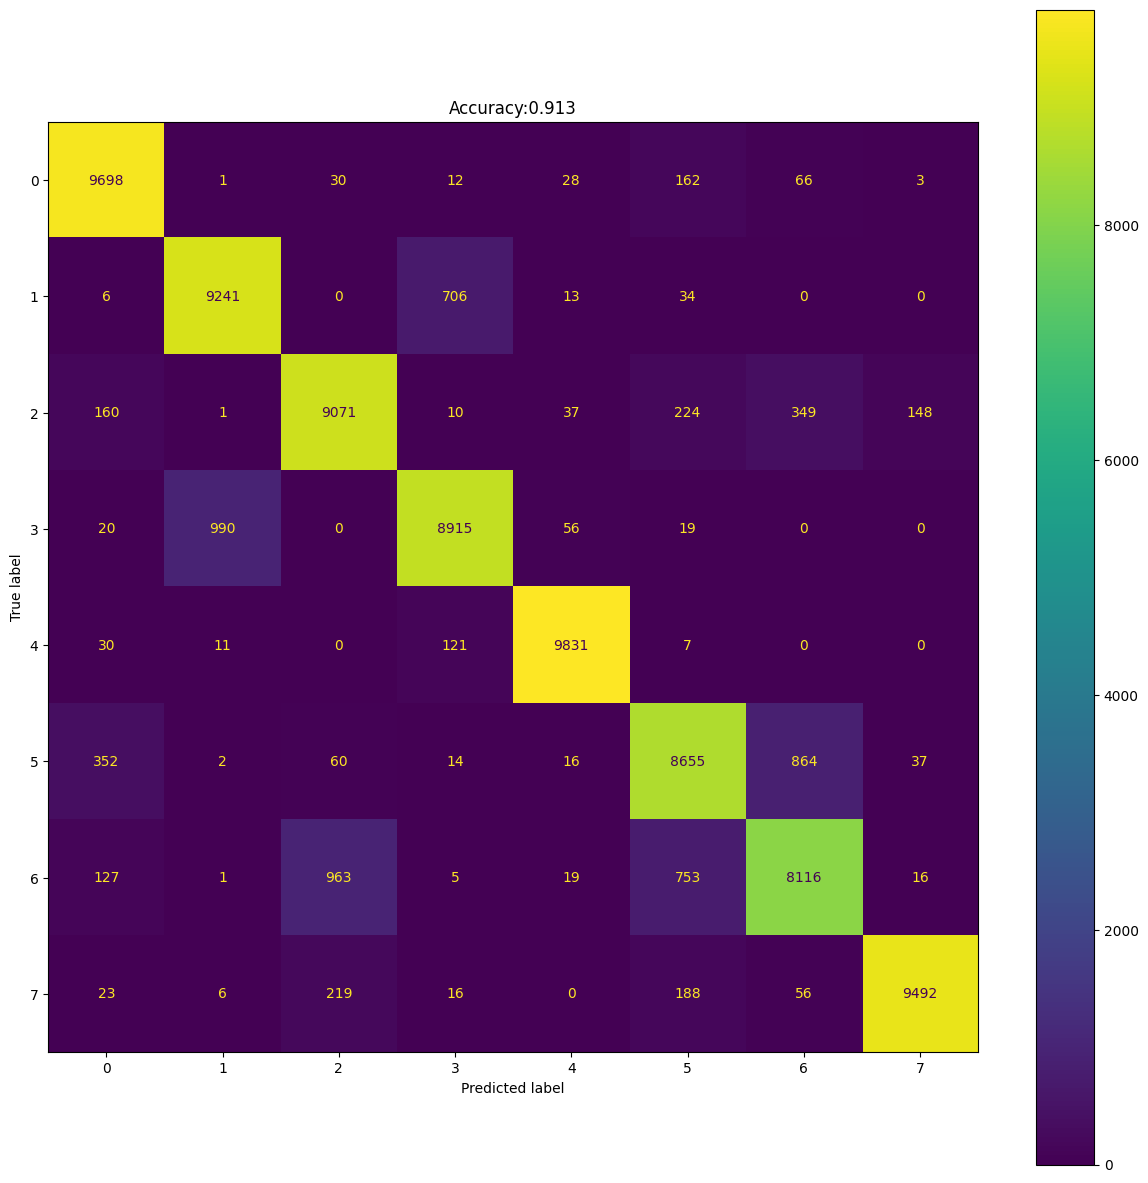

In [38]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(i) model to Nordic Device-30(ii) dataset 

In [39]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [40]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 4.1259 - accuracy: 0.1727
test loss, test acc: [4.1259026527404785, 0.17270000278949738]


In [41]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 0 0 ... 5 5 5]
7
[[ 105    0 9804   82    0    4    4    1]
 [   1  318    0   90 9553    0   37    1]
 [ 124    0 1027   11    0 7003    3 1832]
 [   0    0   12  130 9855    0    2    1]
 [   0    1    4 1161 8832    0    0    2]
 [ 555    0 7192    5    0 2208    7   33]
 [3816    0 6068    4    0   98    5    9]
 [  25    1   44    2    0 8737    0 1191]]
              precision    recall  f1-score   support

           0       0.02      0.01      0.01     10000
           1       0.99      0.03      0.06     10000
           2       0.04      0.10      0.06     10000
           3       0.09      0.01      0.02     10000
           4       0.31      0.88      0.46     10000
           5       0.12      0.22      0.16     10000
           6       0.09      0.00      0.00     10000
           7       0.39      0.12      0.18     10000

    accuracy                           0.17     80000
   macro avg       0.26      0.17  

Test Accuracy:0.1727


Text(0.5, 1.0, 'Accuracy:0.173')

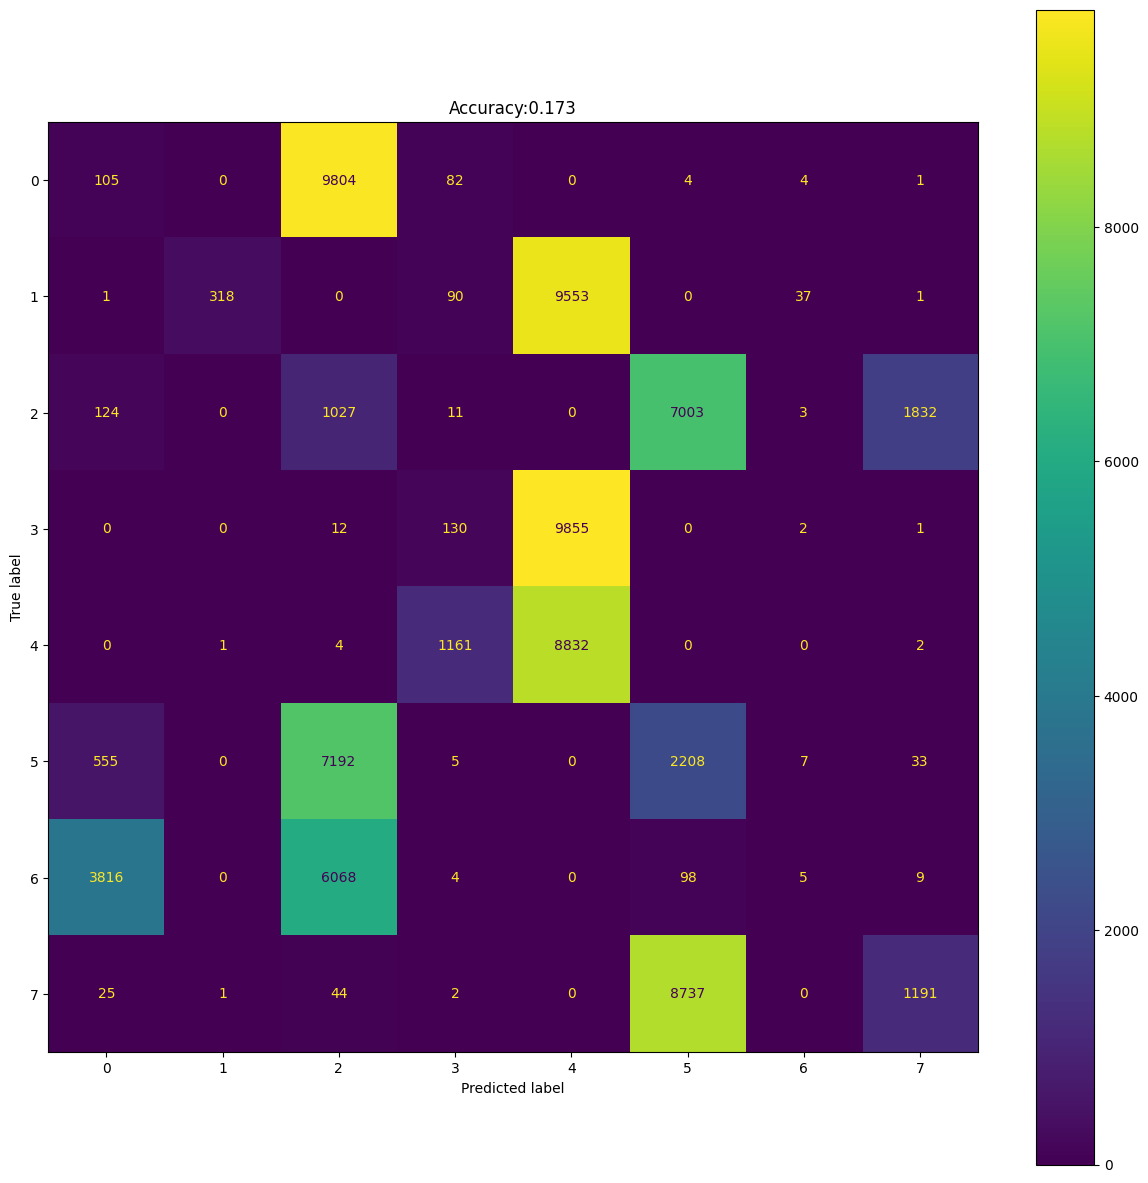

In [42]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [43]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [44]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [45]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9294 - accuracy: 0.6569
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4783 - accuracy: 0.8572
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4267 - accuracy: 0.8816
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4027 - accuracy: 0.8916
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3873 - accuracy: 0.8975
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3764 - accuracy: 0.9018
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3682 - accuracy: 0.9045
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3618 - accuracy: 0.9067
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3567 - accuracy: 0.9086
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss: 

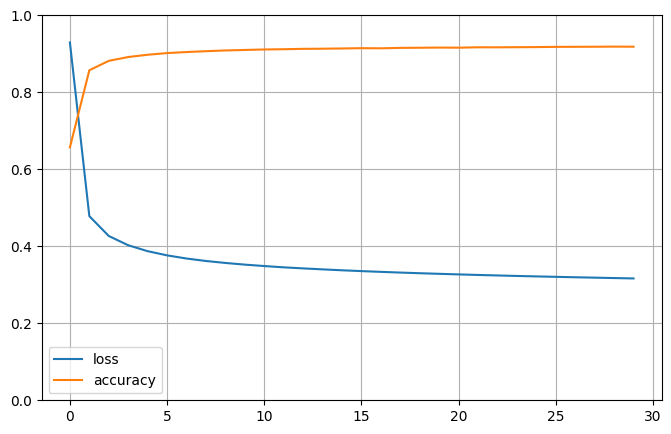

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [47]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.3158 - accuracy: 0.9189
test loss, test acc: [0.31577661633491516, 0.9189375042915344]


In [48]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 6 6 ... 7 7 7]
7
[[9757    2   14    0    3   16  207    1]
 [   3 9630    1  346   14    0    6    0]
 [  47    3 9197    0    5  551  137   60]
 [  29  342    2 9118  502    0    7    0]
 [  11   61    2  538 9387    0    1    0]
 [ 134    2  488    0    0 8566  789   21]
 [  66    0   42    0    2 1664 8217    9]
 [  17    2  238    0    1   81   18 9643]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10000
           1       0.96      0.96      0.96     10000
           2       0.92      0.92      0.92     10000
           3       0.91      0.91      0.91     10000
           4       0.95      0.94      0.94     10000
           5       0.79      0.86      0.82     10000
           6       0.88      0.82      0.85     10000
           7       0.99      0.96      0.98     10000

    accuracy                           0.92     80000
   macro avg       0.92      0.92  

Test Accuracy:0.9189375


Text(0.5, 1.0, 'Accuracy:0.919')

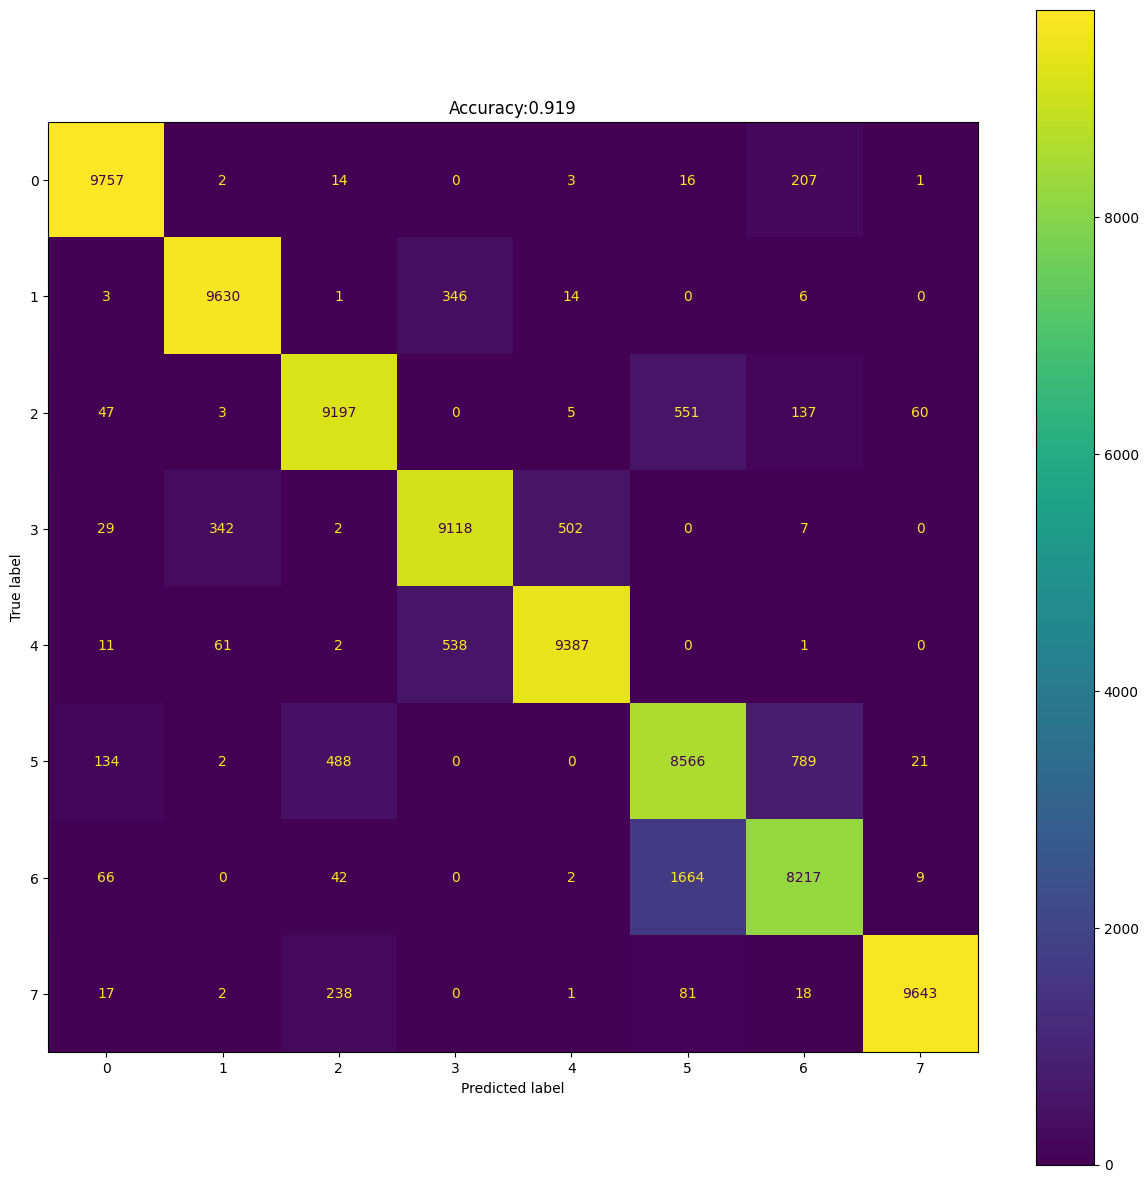

In [49]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-30(ii) dataset 

In [50]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [51]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 7.2858 - accuracy: 0.3727
test loss, test acc: [7.285807132720947, 0.37267500162124634]


In [52]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[7 5 5 ... 7 7 7]
7
[[   0    0    9  886    0 9096    5    4]
 [ 266 9649   61    2   17    5    0    0]
 [   0    0   10   19    0  427   24 9520]
 [9727   34  201   37    0    1    0    0]
 [   4    9 9353   21  560   30   20    3]
 [   0    5   35   36   60 9725   92   47]
 [   1    0    9   19    7 9924   12   28]
 [   0    0    0    1    8   79   91 9821]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       1.00      0.96      0.98     10000
           2       0.00      0.00      0.00     10000
           3       0.04      0.00      0.01     10000
           4       0.86      0.06      0.11     10000
           5       0.33      0.97      0.50     10000
           6       0.05      0.00      0.00     10000
           7       0.51      0.98      0.67     10000

    accuracy                           0.37     80000
   macro avg       0.35      0.37   

Test Accuracy:0.372675


Text(0.5, 1.0, 'Accuracy:0.373')

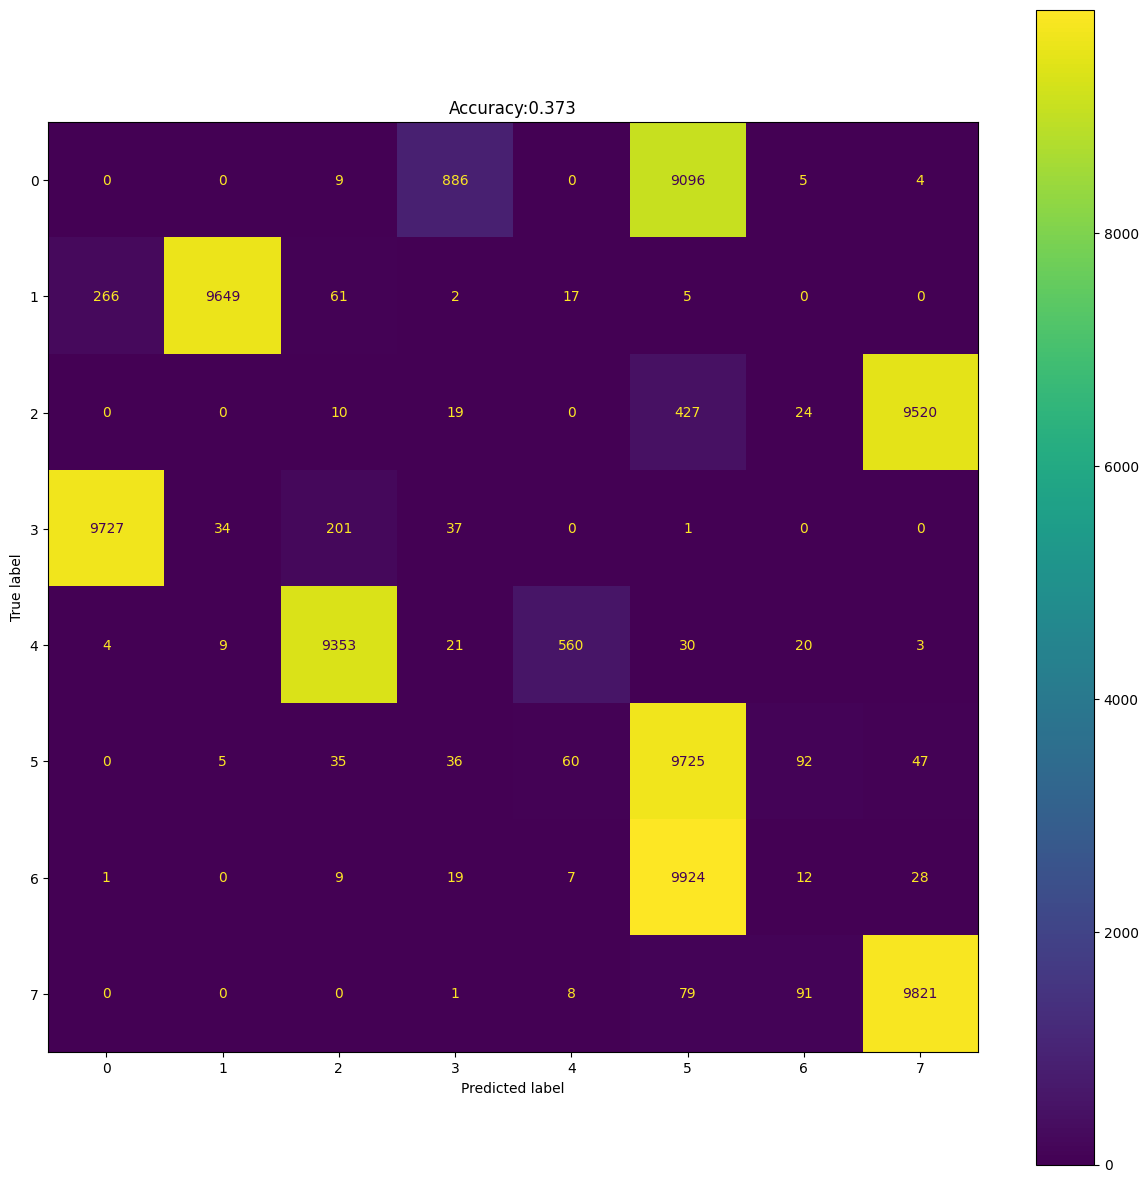

In [53]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [54]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [55]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [56]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2412 - accuracy: 0.6593
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4698 - accuracy: 0.7793
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3948 - accuracy: 0.8581
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3604 - accuracy: 0.9001
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3412 - accuracy: 0.9125
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3283 - accuracy: 0.9182
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3191 - accuracy: 0.9210
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3119 - accuracy: 0.9238
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3061 - accuracy: 0.9251
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.30

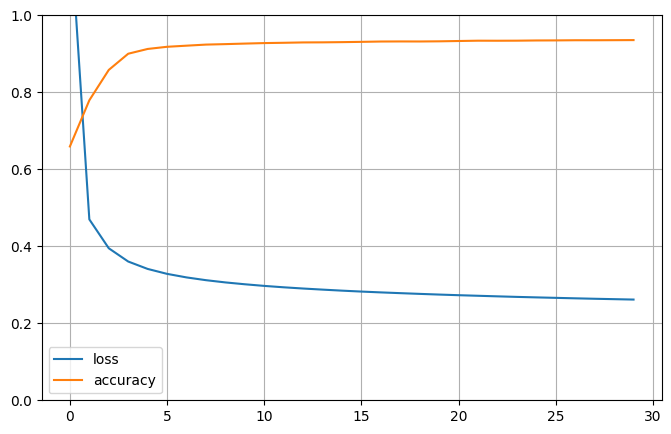

In [57]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [58]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2608 - accuracy: 0.9363
test loss, test acc: [0.2607833743095398, 0.9363250136375427]


In [59]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 6 6 ... 7 7 7]
2
[[9685    0    7    2   11   19  276    0]
 [   1 9880    0   66   50    3    0    0]
 [  90    0 9594    2   14   84  140   76]
 [  30   88    0 9814   68    0    0    0]
 [  66   12    3   42 9829   48    0    0]
 [ 165    9   94    0   69 8392 1252   19]
 [ 134    0  143    2   31 1544 8144    2]
 [  12    0  245    0    7  146   22 9568]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10000
           1       0.99      0.99      0.99     10000
           2       0.95      0.96      0.96     10000
           3       0.99      0.98      0.98     10000
           4       0.98      0.98      0.98     10000
           5       0.82      0.84      0.83     10000
           6       0.83      0.81      0.82     10000
           7       0.99      0.96      0.97     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94   

Test Accuracy:0.936325


Text(0.5, 1.0, 'Accuracy:0.936')

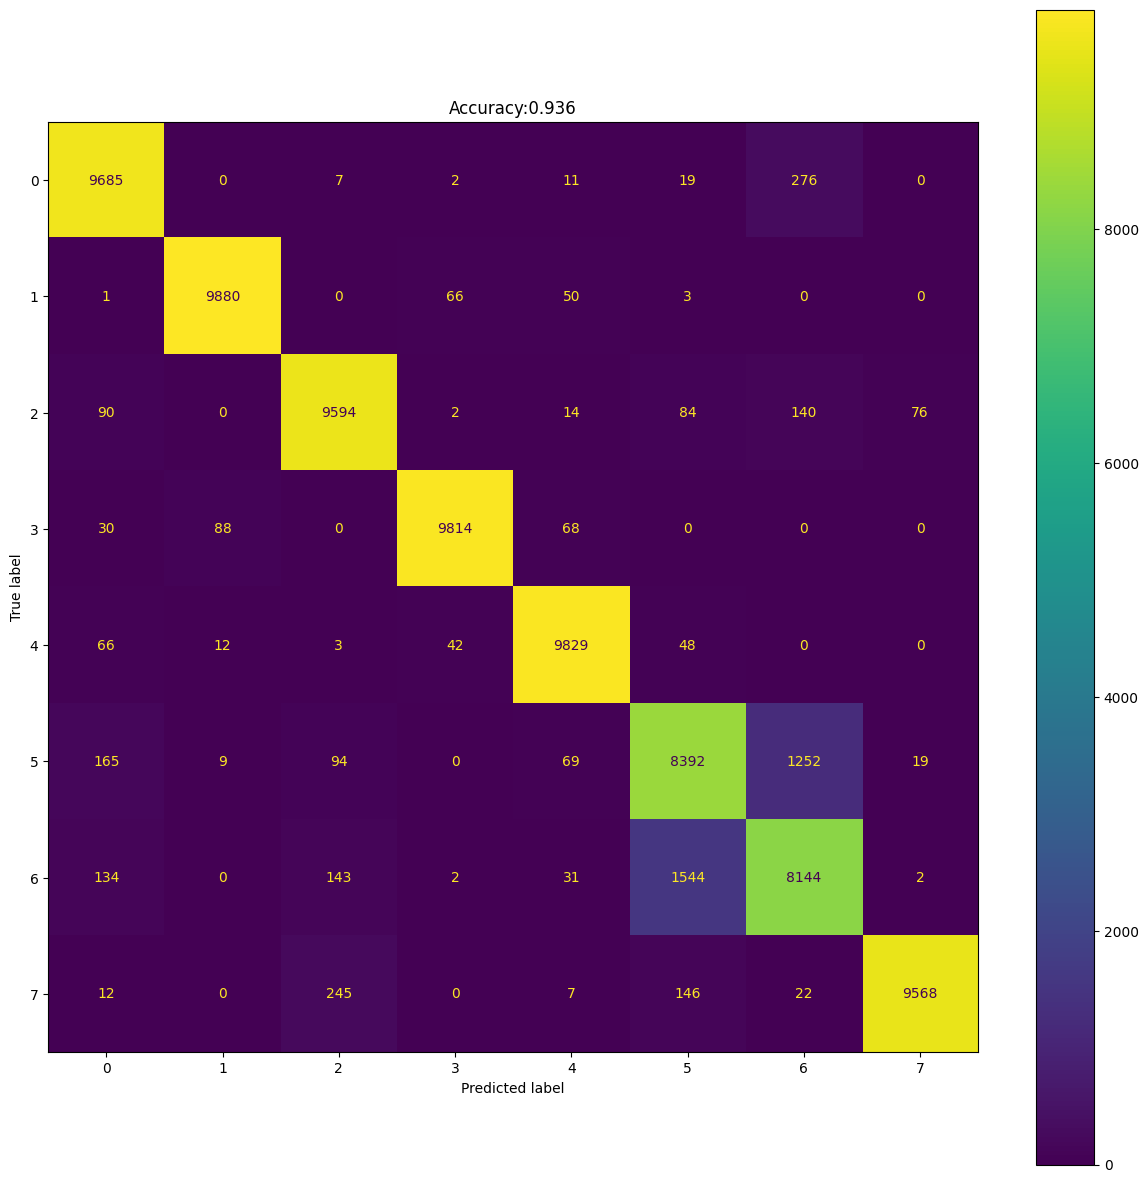

In [60]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')